In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 학습, 검증, 테스트 데이터 로드
train_df = pd.read_csv('train.hate.csv')  # 학습 데이터 로드
dev_df = pd.read_csv('dev.hate.csv')      # 검증 데이터 로드
test_df = pd.read_csv('test.hate.no_label.csv')    # 테스트 데이터 로드

In [2]:
# 라벨링 변환 (예: 'no' -> 0, 'offensive' -> 1, 'hate' -> 2)
label_mapping = {'no': 0, 'offensive': 1, 'hate': 2}
train_df['label'] = train_df['label'].map(label_mapping)
dev_df['label'] = dev_df['label'].map(label_mapping)

# 결측치 확인 및 제거
train_df = train_df.dropna(subset=['label', 'comments'])
dev_df = dev_df.dropna(subset=['label', 'comments'])

# 데이터셋 확인
if train_df.empty:
    raise ValueError("학습 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")
if dev_df.empty:
    raise ValueError("검증 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")

In [3]:
from transformers import ElectraForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch

# KcELECTRA 모델과 토크나이저 로드
model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

def encode_data(data):
    # 텍스트 토큰화 및 변환
    encodings = tokenizer(
        data['comments'].tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # max_length를 지정하여 입력 길이 제한
    )
    return encodings

# 학습 및 검증 데이터 토큰화
train_encodings = encode_data(train_df)
val_encodings = encode_data(dev_df)

# 라벨을 텐서로 변환
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(dev_df['label'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [5]:
best_params = {
    'num_train_epochs': 3,
    'per_device_train_batch_size': 16,
    'learning_rate': 5e-5
}

# TrainingArguments에 정규화 기법 추가 (weight_decay)
training_args = TrainingArguments(
    output_dir='./best_results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    learning_rate=best_params['learning_rate'],
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.1,  # 정규화 기법으로 weight decay 적용
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./best_logs',
    logging_steps=10,
    report_to="none",
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.742600,0.913911
2,0.561900,0.744216
3,0.288600,0.901776


TrainOutput(global_step=1482, training_loss=0.6365727412234112, metrics={'train_runtime': 106.4832, 'train_samples_per_second': 222.458, 'train_steps_per_second': 13.918, 'total_flos': 900809897063328.0, 'train_loss': 0.6365727412234112, 'epoch': 3.0})

In [6]:
# 모델 훈련 후 평가 지표 계산 및 혼동 행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가 및 예측
predictions = trainer.predict(val_dataset)
y_preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
y_true = val_labels.numpy()

# 평가 지표 출력
print(classification_report(y_true, y_preds, target_names=['no', 'offensive', 'hate']))

              precision    recall  f1-score   support

          no       0.67      0.93      0.78       160
   offensive       0.67      0.55      0.60       189
        hate       0.79      0.61      0.69       122

    accuracy                           0.69       471
   macro avg       0.71      0.70      0.69       471
weighted avg       0.70      0.69      0.69       471



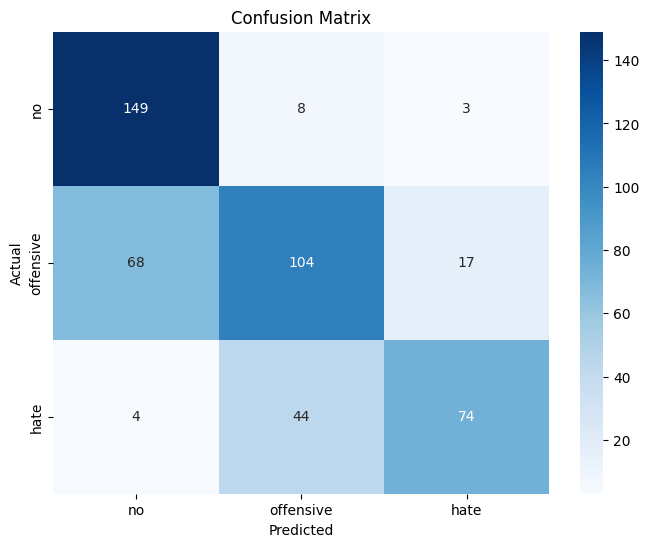

In [7]:
# 혼동 행렬 그리기
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'offensive', 'hate'], yticklabels=['no', 'offensive', 'hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
# 모델 및 토크나이저 저장
model.save_pretrained('./saved_model_v6')
tokenizer.save_pretrained('./saved_model_v6')

('./saved_model_v6/tokenizer_config.json',
 './saved_model_v6/special_tokens_map.json',
 './saved_model_v6/tokenizer.json')

In [11]:
# 테스트 데이터 예측 및 CSV 저장
test_encodings = encode_data(test_df)
test_dataset = CustomDataset(test_encodings)
test_predictions = trainer.predict(test_dataset)
test_preds = torch.argmax(torch.tensor(test_predictions.predictions), axis=1)

output_df = test_df.copy()
output_df['label'] = test_preds.numpy()
output_df.to_csv('test.hate.predicted_KcELECTRA_v6_weight.csv', index=False)
print("테스트 데이터의 예측 결과가 test.hate.predicted_KcELECTRA_v6.csv 파일에 저장되었습니다.")


테스트 데이터의 예측 결과가 test.hate.predicted_KcELECTRA_v6.csv 파일에 저장되었습니다.
